In [4]:
import matplotlib.pyplot as plt 
import os
import numpy as np
import cv2
import seaborn as sns

In [5]:
def load_dataset(dataset, path):
    labels = os.listdir(os.path.join(path, dataset))

    x = []
    y = []


    for label in labels:
        for file in os.listdir(os.path.join(path, dataset, label)):
            image = cv2.imread(os.path.join(path, dataset, label, file), cv2.IMREAD_GRAYSCALE)

            x.append(image)
            y.append(label)

    return np.array(x), np.array(y).astype('uint8')

def create_dataset(path):
    x, y = load_dataset("train", path)
    x_test, y_test = load_dataset("test", path)

    return x, y, x_test, y_test

In [7]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        pass

    def load_params(self, new_weights, new_biases):
        self.weights = new_weights
        self.biases = new_biases


    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

In [8]:
class Activation_RELU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

In [9]:
class Activation_Sigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    # Backward propagation function
    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output) * self.output

In [10]:
class Loss:
    def calculate(self, output, y):
       
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)

        return data_loss


    def calculate_accumulated(self):
        data_loss = self.accumulated_sum / self.accumulated_count
        return data_loss

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

class Loss_BinaryCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculating sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        return sample_losses

    def backward(self, dvalues, y_true):
        n_samples = len(dvalues)
        n_outputs = len(dvalues[0])

        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        self.dinputs = -(y_true / clipped_dvalues - (1 - y_true) / (1 - clipped_dvalues)) / n_outputs
        self.dinputs = self.dinputs / n_samples
        

In [11]:
class Optimizer_SGD:
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        layer.weights += weight_updates
        layer.biases += bias_updates


    def post_update_params(self):
        self.iterations += 1

In [12]:
class Accuracy:
    def calculate(self, predictions, y):
        comparisons = (predictions == y)   
        accuracy = np.mean(comparisons)    

        # Sum up the total correct predictions and total predictions for accumulated accuracy
        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)
        return accuracy

    # Calculate accumulated accuracy over multiple batches
    def calculate_accumulated(self):
        accumulated_accuracy = self.accumulated_sum / self.accumulated_count
        return accumulated_accuracy


    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0


In [13]:
def label_to_onehot(nplist):
    nplist[nplist == 2] = 1
    nplist[nplist == 7] = 0

def onehot_to_label(nplist):
    nplist[nplist == 1] = 2
    nplist[nplist == 0] = 7
    

In [14]:
x_og, y, x_test_og, y_test = create_dataset("D:\IB\EE\dataset EDITTED")
print('Dataset Created')

<>:1: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\I'
/var/folders/jt/kvjxrj791q9bw6dzxw92c_nw0000gn/T/ipykernel_46216/1333775734.py:1: SyntaxWarning: invalid escape sequence '\I'
  x_og, y, x_test_og, y_test = create_dataset("D:\IB\EE\dataset EDITTED")
/var/folders/jt/kvjxrj791q9bw6dzxw92c_nw0000gn/T/ipykernel_46216/1333775734.py:1: SyntaxWarning: invalid escape sequence '\I'
  x_og, y, x_test_og, y_test = create_dataset("D:\IB\EE\dataset EDITTED")


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\IB\\EE\\dataset EDITTED/train'

In [32]:
x = (x_og.reshape(x_og.shape[0], x_og.shape[1]*x_og.shape[2]).astype(np.float32) - 127.5)/127.5
x_test = (x_test_og.reshape(x_test_og.shape[0], x_test_og.shape[1] * x_test_og.shape[2]).astype(np.float32) - 127.5)/127.5

In [33]:
keys = np.array(range(x.shape[0]))
np.random.shuffle(keys)
x = x[keys]
y = y[keys]
keys2 = np.array(range(x_test.shape[0]))
np.random.shuffle(keys2)
x_test = x_test[keys2]
x_test_og = x_test_og[keys2]
y_test = y_test[keys2]


In [34]:
y = y.reshape(-1, 1)
label_to_onehot(y)
y_test = y_test.reshape(-1, 1)
label_to_onehot(y_test)

In [35]:
epoch_num = 1000
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
empty = np.zeros_like(y_test)

dense1 = Layer_Dense(x.shape[1], 64)   
activation1 = Activation_RELU()        
dense2 = Layer_Dense(64, 1)            
activation2 = Activation_Sigmoid()     

loss_function = Loss_BinaryCrossentropy()

accuracy = Accuracy()
optimizer = Optimizer_SGD(learning_rate=0.01, decay=0, momentum=0)

for epoch in range(epoch_num):
    if not (epoch % 10):
        print(f'epoch: {epoch}')

    # Define batch size and calculate number of steps required in each epoch
    train_steps = 1
    batch_size = 128
    if batch_size is not None:
        train_steps = len(x) // batch_size
        if train_steps * batch_size < len(x):
            train_steps += 1

    loss_function.new_pass()
    accuracy.new_pass()


    for step in range(train_steps):

        batch_x = x[step*batch_size:(step+1)*batch_size]
        batch_y = y[step*batch_size:(step+1)*batch_size]

        # Forward pass
        dense1.forward(batch_x)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)

        # Calculate loss and accuracy for this batch
        loss = loss_function.calculate(activation2.output, batch_y)
        predictions = (activation2.output > 0.5) * 1
        
        accuracy_ = accuracy.calculate(predictions, batch_y)

        # Backward pass
        loss_function.backward(activation2.output, batch_y)
        activation2.backward(loss_function.dinputs)
        dense2.backward(activation2.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)

        # Update weights and biases based on gradients
        optimizer.pre_update_params()
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.post_update_params()

    # Calculate accumulated loss and accuracy over the entire epoch
    epoch_data_loss = loss_function.calculate_accumulated()
    train_loss.append(epoch_data_loss)
    epoch_accuracy = accuracy.calculate_accumulated()
    train_accuracy.append(epoch_accuracy)
    


    if not epoch % 10:
        print(f'epoch acc: {epoch_accuracy:3f} ' +
              f'epoch data loss: {epoch_data_loss:3f} ' +
              f'lr: {optimizer.current_learning_rate}')
        

    #validation
    
    loss_function.new_pass()
    accuracy.new_pass()

    validation_steps = len(x_test) // batch_size
    if validation_steps * batch_size < len(x_test):
        validation_steps += 1

    for step in range(validation_steps):
        if batch_size is None:
            batch_x = x_test
            batch_y = y_test
        else:
            batch_x = x_test[step*batch_size:(step+1)*batch_size]
            batch_y = y_test[step*batch_size:(step+1)*batch_size]

        # Forward pass on the validation set
        dense1.forward(batch_x)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
        
        loss = loss_function.calculate(activation2.output, batch_y)
        
        val_predictions = (activation2.output > 0.5) * 1
        
        accuracy_ = accuracy.calculate(val_predictions,batch_y)
    validation_loss = loss_function.calculate_accumulated()
    val_loss.append(validation_loss)
    validation_accuracy = accuracy.calculate_accumulated()
    val_accuracy.append(validation_accuracy)

    if not epoch % 10:
        print(f'validation, acc: {validation_accuracy:3f}, '+
              f'loss: {validation_loss:3f}')
    
    if epoch == epoch_num - 1:
        best_weights1 = dense1.weights.copy()
        best_weights2 = dense2.weights.copy()
        best_bias1 = dense1.biases.copy()
        best_bias2 = dense2.biases.copy()

epoch: 0
epoch acc: 0.505875 epoch data loss: 0.691885 lr: 0.01
validation, acc: 0.506000, loss: 0.690492
epoch: 10
epoch acc: 0.856500 epoch data loss: 0.364658 lr: 0.01
validation, acc: 0.869500, loss: 0.347470
epoch: 20
epoch acc: 0.893875 epoch data loss: 0.276911 lr: 0.01
validation, acc: 0.908500, loss: 0.275790
epoch: 30
epoch acc: 0.903875 epoch data loss: 0.256816 lr: 0.01
validation, acc: 0.907500, loss: 0.263205
epoch: 40
epoch acc: 0.909500 epoch data loss: 0.248143 lr: 0.01
validation, acc: 0.910000, loss: 0.258081
epoch: 50
epoch acc: 0.910750 epoch data loss: 0.242957 lr: 0.01
validation, acc: 0.913000, loss: 0.254908
epoch: 60
epoch acc: 0.912125 epoch data loss: 0.238215 lr: 0.01
validation, acc: 0.917000, loss: 0.251832
epoch: 70
epoch acc: 0.913250 epoch data loss: 0.234451 lr: 0.01
validation, acc: 0.918000, loss: 0.248779
epoch: 80
epoch acc: 0.914125 epoch data loss: 0.228673 lr: 0.01
validation, acc: 0.921500, loss: 0.243535
epoch: 90
epoch acc: 0.916750 epoch da

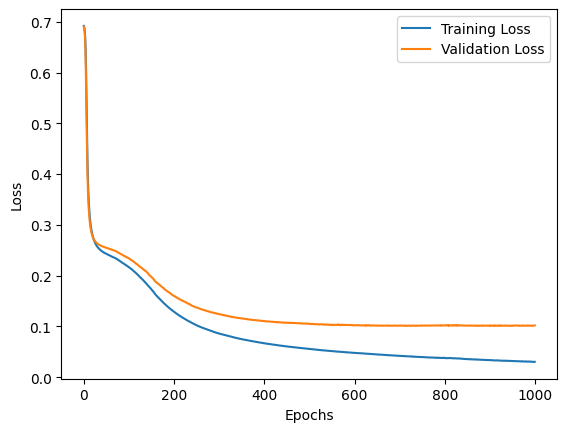

In [36]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

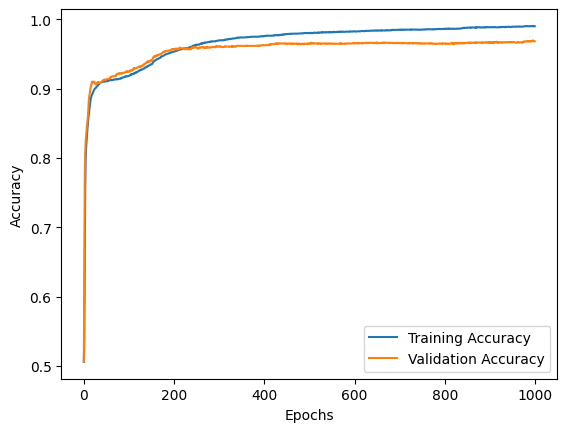

In [37]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

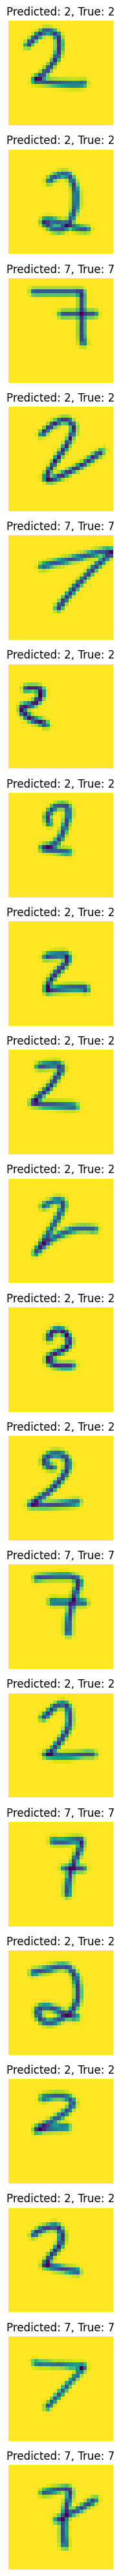

In [101]:
testdense1 = Layer_Dense(x.shape[1], 64)   
testactivation1 = Activation_RELU()        
testdense2 = Layer_Dense(64, 1)            
testactivation2 = Activation_Sigmoid()    

testdense1.load_params(best_weights1, best_bias1)
testdense2.load_params(best_weights2, best_bias2)

testdense1.forward(x_test)
testactivation1.forward(testdense1.output)
testdense2.forward(testactivation1.output)
testactivation2.forward(testdense2.output)

pred1 = (testactivation2.output > 0.5) * 1

sample_images = x_test_og[500:520]
pred_edit = pred1[500:520]
onehot_to_label(pred_edit)
true_edit = y_test[500:520]
onehot_to_label(true_edit)


fig, axes = plt.subplots(nrows=len(sample_images), ncols=1, figsize=(8, 2 * len(sample_images)))
for i, (image, predicted_label, true_label) in enumerate(zip(sample_images, pred_edit, 
true_edit)):
 axes[i].imshow(image)
 axes[i].set_title(f'Predicted: {predicted_label[0]}, True: {true_label[0]}')
 axes[i].axis('off')
plt.tight_layout()
plt.show()


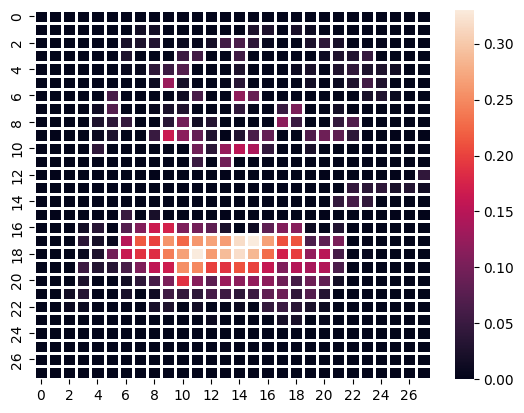

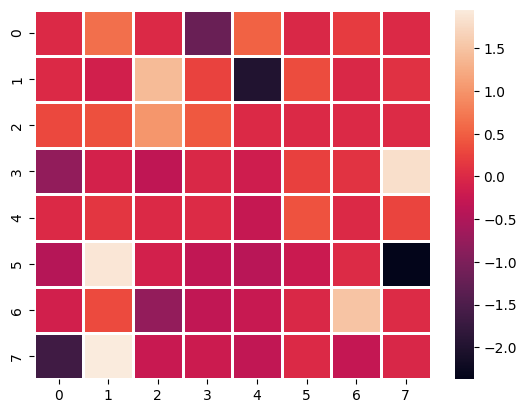

In [124]:
nparray = best_weights1.T[57].copy().reshape((28,28))
vmin=0
ax = sns.heatmap(nparray, linewidth=2, vmin=vmin)
plt.show()

nparray = best_weights2.T[0].copy().reshape((8,8))
ax = sns.heatmap(nparray, linewidth=2)
plt.show()